Load the libraries

In [1]:
!pip install tensorflow-addons

^C
ERROR: Operation cancelled by user


In [1]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("No GPU found, model running on CPU")
import tensorflow_addons as tfa
from skimage.transform import warp, AffineTransform
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd
import math
import seaborn as sns
tf.random.set_seed(42)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Data Loading and preprocessing

Link dataset in tfrecords: https://drive.google.com/open?id=1sz5MURqR_S_-f4niCx3dYeMXAljowWRt

In [2]:
@tf.function
def apply_random_scaling(image, minval=-.02, maxval=.02):
    param = tf.random.uniform([], minval=minval, maxval=maxval)
    source_size = image.shape
    target_size = tf.cast(source_size[0]*(1.0+param), tf.int32), tf.cast(source_size[1]*(1.0+param), tf.int32)
    output = tf.image.resize_with_crop_or_pad(tf.image.resize(image, target_size), source_size[0], source_size[1])
    return output, param

def apply_random_shearing(image, minval=-5., maxval=5.):
    #param = tf.random.uniform([], minval=tf.math.atan(minval/image.shape[1]), maxval=tf.math.atan(maxval/image.shape[1]))
    #param = tf.random.uniform([], minval=tf.math.atan(), maxval=tf.math.atan(maxval/image.shape[1]))
    param = np.random.uniform(low=minval, high=maxval)
    output = warp(np.array(image), AffineTransform(shear=np.arctan(param/image.shape[1])).inverse)
    return output, param
@tf.function
def apply_random_rotation(image, minval=-7, maxval=7):
    param = tf.random.uniform([], minval=minval, maxval=maxval)
    output = tfa.image.rotate(image, param*math.pi/180.0, interpolation='BILINEAR')
    return output, param


def apply_test_time_augmentation(image, labels, image_id):
    '''Implements TTA, https://arxiv.org/pdf/1911.06475.pdf pag13:
    
    (...) for each test CXR, we applied a random 
    transformation (amongst horizontal flipping, 
    rotating ±7 degrees, scaling±2%,and shearing±5 pixels) 10 times (...)
    
    :param image - the input image
    :param labels - the labels associated with the image
    :param image_id - an ordinal or id associated with the image
    
    :returns - a DataFrame containing one row for each generated image (+1 for the original one), a list of generated images and labels. 
    The dataframe contains the augmentation method used, the parameter and the image/label filenames.
    '''
    dataframe = pd.DataFrame()
    image_list = list()
    image_list.append((image, labels))
    
    dataframe = dataframe.append({'image_id':image_id,
                                      'tta_id':0,
                                      'image_fn':'{}_{}_image.npy'.format(image_id, 0),
                                      'labels_fn':'{}_label.npy'.format(image_id),
                                      'method':'ORIGINAL',
                                      'param':0.0}, ignore_index=True)
    
    for i in range(1, 11):

        random_function = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)

        output = image
        param = tf.constant(0.0)        
        
        if tf.equal(random_function, 0):
            output = tf.image.flip_left_right(image)
            param = tf.constant(0.0)
            method = 'FLIP'
        if tf.equal(random_function, 1):
            output, param = apply_random_rotation(image)
            method = 'ROTATION'
        if tf.equal(random_function, 2):
            output, param = apply_random_scaling(image)
            method = 'SCALING'
        if tf.equal(random_function, 3):
            output, param = apply_random_shearing(image)
            method = 'SHEAR'
        image_list.append((output, labels))
        
        dataframe = dataframe.append({'image_id':image_id,
                                      'tta_id':int(i),
                                      'image_fn':'{}_{}_image.npy'.format(image_id, i),
                                      'labels_fn':'{}_label.npy'.format(image_id),
                                      'method':method,
                                      'param':float(param)}, ignore_index=True)
    return dataframe, image_list


def record_parser(example, image_size=224):
    example_fmt = {
        'label': tf.io.FixedLenFeature([14], tf.float32),
        'image': tf.io.FixedLenFeature([],tf.string, default_value='')}
    parsed = tf.io.parse_single_example(example, example_fmt)
    image = tf.io.decode_png(parsed["image"],channels=3)
    image.set_shape([image_size, image_size, 3])
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, parsed['label']

def normalize_image(img,labels):
    imagenet_mean = np.array([0.485, 0.456, 0.406])
    imagenet_std = np.array([0.229, 0.224, 0.225])
    img = (img - imagenet_mean) / imagenet_std
    return img,labels

def make_dataset(filename, image_size=224):
  base_path = 'datasets/'
  full_path = os.path.join(base_path,filename)
  dataset = tf.data.TFRecordDataset(full_path)
  parser = lambda x, size=image_size: record_parser(x, image_size=size)
  parsed_dataset = dataset.map(parser,num_parallel_calls = tf.data.experimental.AUTOTUNE)
  parsed_dataset = parsed_dataset.map(normalize_image,num_parallel_calls = tf.data.experimental.AUTOTUNE)
  return parsed_dataset

def make_tta_dataset(csv_path, test_dataset_path='test_set_cropped.tfrecords', image_size=224):
    '''
    TTA Dataset is built upon the test set. If the csv file exists in the given path, then this function use it to load the dataset.
    Otherwise first the test dataset is loaded and each image is saved in a different numpy file. 
    '''
    tta_images = list()
    tta_labels = list()
    folder = os.path.dirname(csv_path)
    
    if not os.path.isfile(csv_path):
        print("Dataset not found. Generating...")
        # Generate dataset
        # Load test dataset
        
        os.makedirs(folder, exist_ok=True)
        test_dataset = make_dataset(test_dataset_path).prefetch(1)
        # Apply augmentation
        tta_dataset = list()
        tta_csv = pd.DataFrame()
        for r, record in enumerate(test_dataset):
            aug_dataframe, aug_images = apply_test_time_augmentation(record[0], record[1], r)
            tta_csv = tta_csv.append(aug_dataframe, ignore_index=True)
            for (_, (image_fn, labels_fn)), (aug_image, aug_label) in zip(aug_dataframe[['image_fn', 'labels_fn']].iterrows(), aug_images):
                np.save(os.path.join(folder, image_fn), aug_image)
                if _ == 0:
                    np.save(os.path.join(folder, labels_fn), aug_label)
        tta_csv.to_csv(csv_path)
    
    print("Loading dataset "+ csv_path)
    # Load dataset
    csv = pd.read_csv(csv_path, index_col=0)
    for g, augmentation_group in csv.loc[csv['method'] != 'ORIGINAL'].groupby(['image_id']):
        current_aug = list()
        for _, (image_fn, labels_fn) in augmentation_group[['image_fn', 'labels_fn']].iterrows():
            current_aug.append(np.load(os.path.join(folder, image_fn)))
            label = np.load(os.path.join(folder, labels_fn))
        tta_images.append(np.stack(current_aug))
        tta_labels.append(label)
    return tf.data.Dataset.from_tensor_slices((tta_images, tta_labels))
        

batch_size = 64
#train_dataset = make_dataset('training_cropped.tfrecords').shuffle(buffer_size=128).batch(batch_size, drop_remainder=True).prefetch(1)
#val_dataset = make_dataset('validation_cropped.tfrecords').shuffle(buffer_size=128).batch(batch_size, drop_remainder=True).prefetch(1)
#train_dataset = make_dataset('training_cropped.tfrecords').batch(batch_size, drop_remainder=True).prefetch(1)

# UNCOMMENT TO ENABLE TRAINING
# train_dataset = make_dataset('conditional_training.tfrecords').shuffle(buffer_size=128).batch(batch_size, drop_remainder=True).prefetch(1)
val_dataset = make_dataset('validation_cropped.tfrecords').batch(batch_size, drop_remainder=True).prefetch(1)
test_dataset = make_dataset('test_set_cropped.tfrecords').batch(batch_size, drop_remainder=False).prefetch(1)

tta_dataset = make_tta_dataset('datasets/tta_dataset/tta.csv')

# TODO: Since we cannot convert the full pipeline to tensorflow (due to shearing depending on Skimage), the make tta dataset will:
# 1) Compute the dataset if not already present at the given path (using the classical for structure)
# 2) Load the dataset from npy files as a tensorflow dataset

Loading dataset datasets/tta_dataset/tta.csv


In [24]:
val_dataset = make_dataset('validation_cropped.tfrecords').batch(batch_size, drop_remainder=True).prefetch(1).unbatch()
v = 0
for x in val_dataset:
    v+=1
v

1856

In [25]:
x

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[-1.980906  , -1.8956583 , -1.6650109 ],
         [-1.980906  , -1.8956583 , -1.6650109 ],
         [-1.980906  , -1.8956583 , -1.6650109 ],
         ...,
         [-1.8781574 , -1.7906162 , -1.5604358 ],
         [-2.0322802 , -1.9481792 , -1.7172985 ],
         [-1.980906  , -1.8956583 , -1.6650109 ]],
 
        [[-1.980906  , -1.8956583 , -1.6650109 ],
         [-1.980906  , -1.8956583 , -1.6650109 ],
         [-1.9980307 , -1.9131652 , -1.68244   ],
         ...,
         [-1.7754089 , -1.6855742 , -1.4558606 ],
         [-1.7925336 , -1.7030813 , -1.4732897 ],
         [-1.843908  , -1.7556022 , -1.5255773 ]],
 
        [[-1.980906  , -1.8956583 , -1.6650109 ],
         [-1.980906  , -1.8956583 , -1.6650109 ],
         [-1.9980307 , -1.9131652 , -1.68244   ],
         ...,
         [-1.7240347 , -1.6330532 , -1.403573  ],
         [-1.8096584 , -1.7205882 , -1.490719  ],
         [-1.7411594 , -1.6505601 , -1.4210021

# Model Training

In [ ]:
from tensorflow.keras.applications.densenet import DenseNet201,DenseNet121,DenseNet169
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.nasnet import NASNetMobile
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Activation, Lambda
from tensorflow.keras.models import Model

base_model = DenseNet121(include_top=False,
                             weights='imagenet',
                             input_shape=(224, 224, 3))



x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(14, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam

def step_decay(epoch):
  initial_lr = 1e-4
  drop = 0.1
  return initial_lr * np.power(drop,epoch)

outputFolder = '/content/drive/My Drive/Models320/VGG19'
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)
filepath=outputFolder+"/model-{epoch:02d}.hdf5"

lr_scheduler = LearningRateScheduler(step_decay)
early_stopping = EarlyStopping(monitor='val_AUC',mode='max',patience=4)
checkpoint_cb = ModelCheckpoint(filepath,save_best_only = False,save_weights_only = False,
                               save_freq='epoch',verbose=False)


opt = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
callbacks = [lr_scheduler,checkpoint_cb,early_stopping]

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy','AUC'])

In [ ]:
%%time
history = model.fit(train_dataset,
          epochs=5,
          validation_data=val_dataset,
          callbacks=callbacks,
          verbose=1,initial_epoch = 0)

# Load Models

Link alla cartella contenente i modelli trainati: https://drive.google.com/open?id=1EkuS27OzYyQ4fqfiNQdcrO6nQkyKBJ9B

In [3]:
ENABLE_CONDITIONAL_TRAINING = True

In [4]:
from tensorflow.keras.models import load_model

def load_models(base_path):
      models = []
      model_names = sorted(os.listdir(base_path))
      for model in model_names:
        print('loading model: {}'.format(model))
        models.append(load_model(os.path.join(base_path,model)))
      return models, model_names

if ENABLE_CONDITIONAL_TRAINING:
    model_names = ['DenseNet121','DenseNet169','DenseNet201','VGG16','VGG19','Xception','InceptionResNetV2']

    models = []
    for el in model_names:
      mod = load_model('ConditionalTraining/{}/FineTuning/model-05.hdf5'.format(el))
      models.append(mod)
else:
    base_path = './Models/'
    models, model_names = load_models(base_path)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: keras_applications.inception_resnet_v2 is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


# Model Predictions

In [5]:
def apply_bayes_to_predictions(predictions):
  predictions[:,5] = predictions[:,3] * predictions[:,5]
  predictions[:,6] = predictions[:,3] * predictions[:,6]
  predictions[:,7] = predictions[:,3] * predictions[:,7]
  predictions[:,4] = predictions[:,3] * predictions[:,4]
  predictions[:,8] = predictions[:,3] * predictions[:,8]
  predictions[:,2] = predictions[:,1] * predictions[:,2]
  return predictions

def predict(model, input_, conditional_training):
    predictions = model.predict(input_)
    if conditional_training:
        return apply_bayes_to_predictions(predictions)
    else:
        return predictions

Test Time Augmentation (TTA) produces each prediction by averaging the result of 10 augmented samples

In [6]:
tta_predictions = list()
test_Y = list()
for augmented_block, label in tta_dataset:
    test_Y.append(label.numpy())
    models_predictions = list()
    for model in models:
        models_predictions.append(np.stack([predict(model, img[tf.newaxis, ...], ENABLE_CONDITIONAL_TRAINING) for img in tf.unstack(augmented_block)]))
    tta_predictions.append(np.stack(models_predictions))
test_Y = np.array(test_Y)    
tta_predictions = np.stack(tta_predictions).squeeze().transpose(1, 0, 2, 3) # Prediction for each augmented image and model
tta_prediction_means = tta_predictions.mean(axis=2)

In [7]:
test_predictions = list()
for i, (image, label) in enumerate(test_dataset.unbatch()):
    models_predictions = list()
    for model in models:
        models_predictions.append(predict(model, image[tf.newaxis, ...], ENABLE_CONDITIONAL_TRAINING))
    test_predictions.append(np.stack(models_predictions))
test_predictions = np.stack(test_predictions)
test_predictions = test_predictions.squeeze().transpose(1, 0, 2)

## TTA Robustness

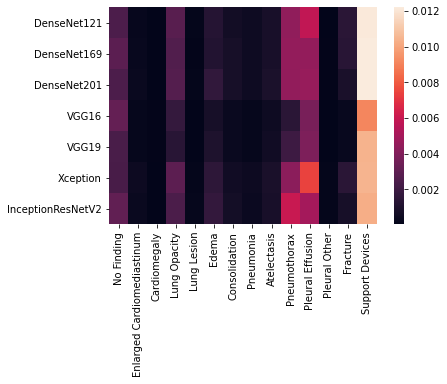

In [9]:
dummy_labels = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
                'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']



# Checking what predictions/models are more robust to TTA

robustness = pd.DataFrame(np.mean(np.var(tta_predictions, axis=(2)), axis=1), columns=dummy_labels, index=model_names)
sns.heatmap(robustness, robust=True)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/usr/local/lib/python3.6/

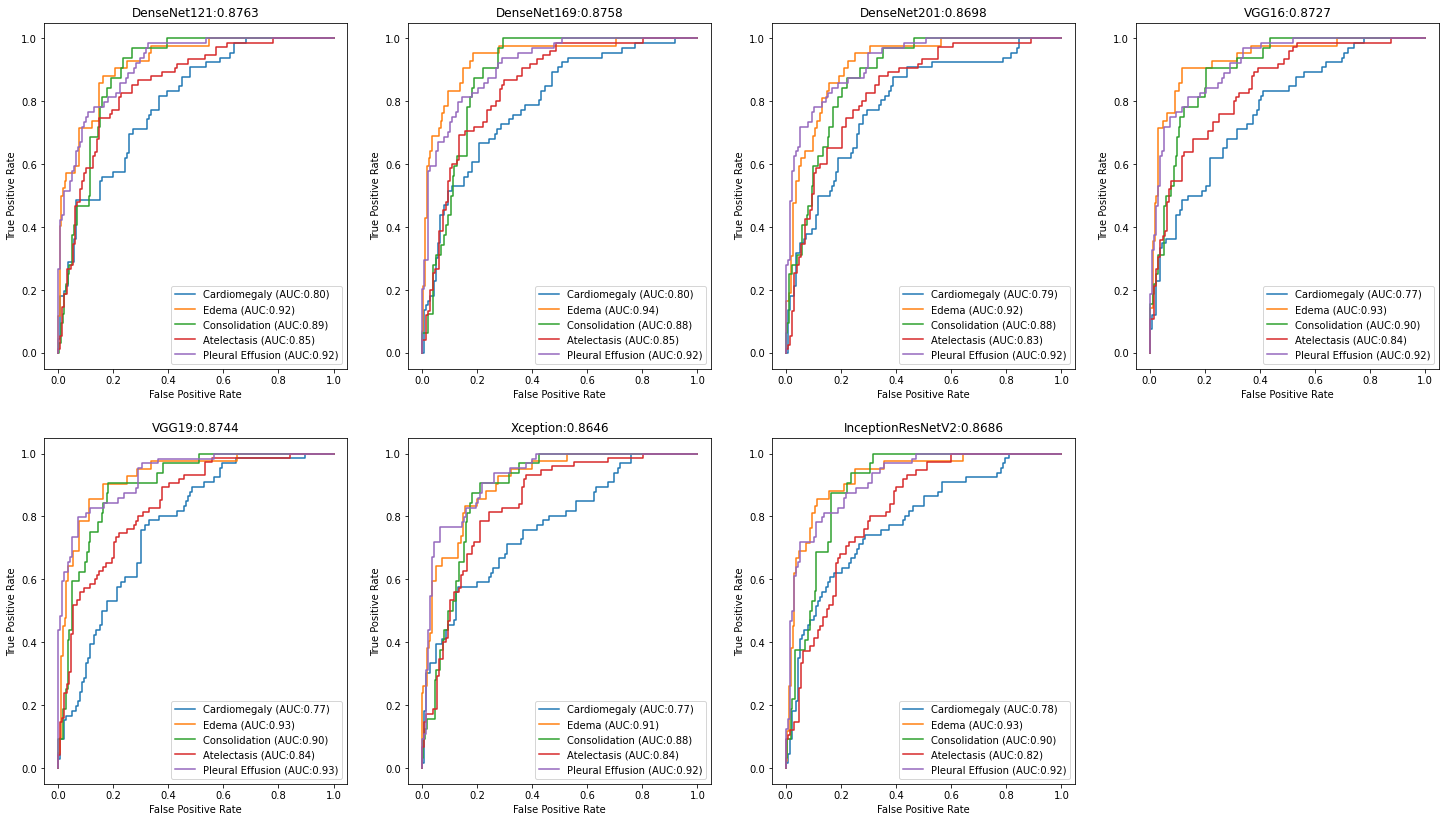

In [8]:
def plot_single_model_performance(predictions):
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt

    dummy_labels = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
                    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

    target_labels = ['Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']

    titles = model_names
    #fig, c_ax = plt.subplots(2,3, figsize = (15, 10))
    fig = plt.figure(figsize=(25,14))
    
    results = pd.DataFrame()

    j = 1
    for model_prediction in predictions:
      aurocs= []
      ax = fig.add_subplot(2,4,j)
      for (i, label) in enumerate(dummy_labels):
          fpr, tpr, thresholds = roc_curve(test_Y[:,i].astype(int), model_prediction[:,i])
          if (label in target_labels):
            #ax = fig.add_subplot(2,3,j)
            score = auc(fpr, tpr)
            ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, score))
            aurocs.append(auc(fpr, tpr))
            results = results.append({'Model':titles[j-1], 'Label': label, 'Score':score},ignore_index = True)
      ax.legend()
      ax.set_xlabel('False Positive Rate')
      ax.set_ylabel('True Positive Rate')
      ax.set_title('{}:{:0.4f}'.format(titles[j-1],np.mean(aurocs)))
      j+=1 
    return results

test_res = plot_single_model_performance(test_predictions).pivot(index='Model', columns='Label')#.to_csv('results/single_model.csv')
#tta_res = plot_single_model_performance(tta_prediction_means).pivot(index='Model', columns='Label').to_csv('results/single_model_tta.csv')
#test_res_nobayes = plot_single_model_performance(test_predictions).pivot(index='Model', columns='Label').to_csv('results/single_model_nobayes.csv')
#tta_res_nobayes = plot_single_model_performance(tta_prediction_means).pivot(index='Model', columns='Label').to_csv('results/single_model_tta_nobayes.csv')

(7, 202, 14)

## Simple Mean

No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


,Label,Score
0,Cardiomegaly,0.810940
1,Edema,0.936161
2,Consolidation,0.908456
3,Atelectasis,0.853543
4,Pleural Effusion,0.933424


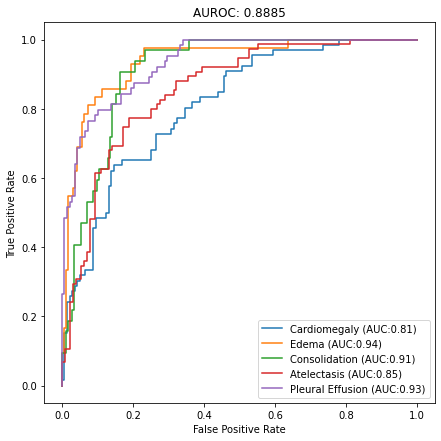

In [17]:
target_labels = ['Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']
dummy_labels = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
                    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

def simple_mean(model_predictions):
    fig, ax = plt.subplots(1,1, figsize = (7, 7))
    j = 1
    aurocs = []
    results = pd.DataFrame()
    for (i, label) in enumerate(dummy_labels):
      fpr, tpr, thresholds = roc_curve(test_Y[:,i].astype(int), model_predictions[:,i])
      
      if (label in target_labels):
        #ax = fig.add_subplot(2,3,j)
        score = auc(fpr, tpr)
        ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, score))
        aurocs.append(auc(fpr, tpr))
        results = results.append({'Label': label, 'Score':score},ignore_index = True)
      ax.legend()
      ax.set_xlabel('False Positive Rate')
      ax.set_ylabel('True Positive Rate')
      ax.set_title('AUROC: {:0.4f}'.format(np.mean(aurocs)))
    return results

simple_mean(test_predictions.mean(axis=0))#.to_csv('results/simple_mean.csv')
#simple_mean(tta_prediction_means.mean(axis=0)).to_csv('results/simple_mean_tta.csv')

# Weighted Predictions

In [18]:
from scipy.stats import entropy

def make_weighted_predictions(predictions):
  entropies = entropy([predictions,1-predictions],base = 2)
  return np.average(predictions,axis=0,weights=1-entropies)

weighted_predictions = make_weighted_predictions(test_predictions)
#weighted_predictions_tta = make_weighted_predictions(tta_prediction_means)

No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


,Label,Score
0,Cardiomegaly,0.811497
1,Edema,0.935714
2,Consolidation,0.911765
3,Atelectasis,0.856483
4,Pleural Effusion,0.930367


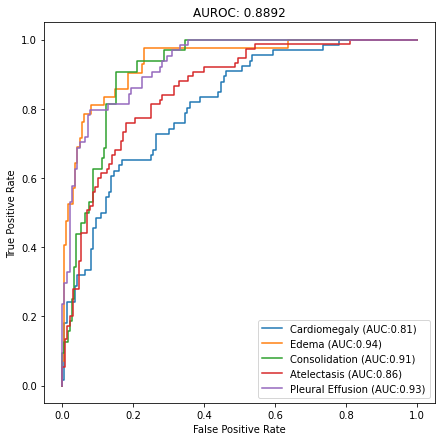

In [19]:
def plot_weighted_predictions(weighted_predictions):
    fig, ax = plt.subplots(1,1, figsize = (7, 7))
    j = 1
    results = pd.DataFrame()
    aurocs = []
    for (i, label) in enumerate(dummy_labels):
      fpr, tpr, thresholds = roc_curve(test_Y[:,i].astype(int), weighted_predictions[:,i])
      if (label in target_labels):
        #ax = fig.add_subplot(2,3,j)
        score = auc(fpr, tpr)
        ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, score))
        aurocs.append(score)
        results = results.append({'Label': label, 'Score':score},ignore_index = True)
      ax.legend()
      ax.set_xlabel('False Positive Rate')
      ax.set_ylabel('True Positive Rate')
      ax.set_title('AUROC: {:0.4f}'.format(np.mean(aurocs)))
    return results
plot_weighted_predictions(weighted_predictions)#.to_csv('results/weighted_mean.csv')
#plot_weighted_predictions(weighted_predictions_tta).to_csv('results/weighted_mean_tta.csv')

# Majority Voting

Majority voting with threshold 0.5

No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-p

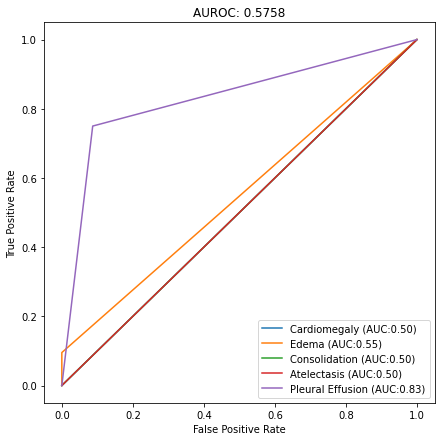

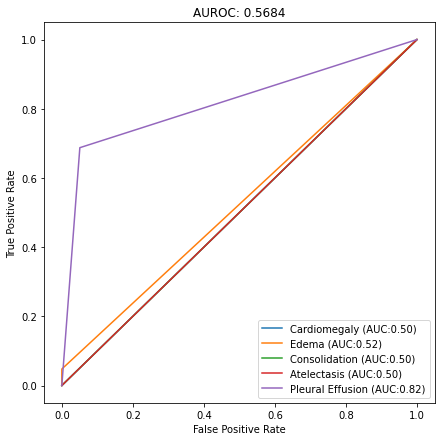

In [13]:
def plot_majority_voting(predictions, threshold=0.5):
    binary_pred = predictions >= threshold
    binary_pred = binary_pred.astype(int)
    votes = binary_pred.sum(axis=0)
    final_pred = votes >=4
    final_pred = final_pred.astype(int)

    fig, ax = plt.subplots(1,1, figsize = (7, 7))
    j = 1
    results = pd.DataFrame()
    aurocs = []
    for (i, label) in enumerate(dummy_labels):
      fpr, tpr, thresholds = roc_curve(test_Y[:,i].astype(int), final_pred[:,i])
      if (label in target_labels):
        #ax = fig.add_subplot(2,3,j)
        score = auc(fpr, tpr)
        ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, score))
        aurocs.append(score)
        results = results.append({'Label': label, 'Score':score},ignore_index = True)
      ax.legend()
      ax.set_xlabel('False Positive Rate')
      ax.set_ylabel('True Positive Rate')
      ax.set_title('AUROC: {:0.4f}'.format(np.mean(aurocs)))
    return results
plot_majority_voting(test_predictions).to_csv('results/majority_voting.csv')
plot_majority_voting(tta_prediction_means).to_csv('results/majority_voting_tta.csv')

Majority voting with threshold 0.2

No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-p

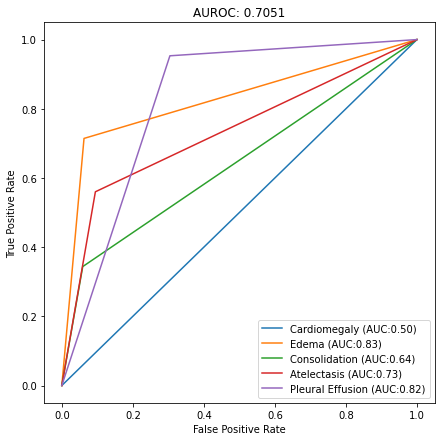

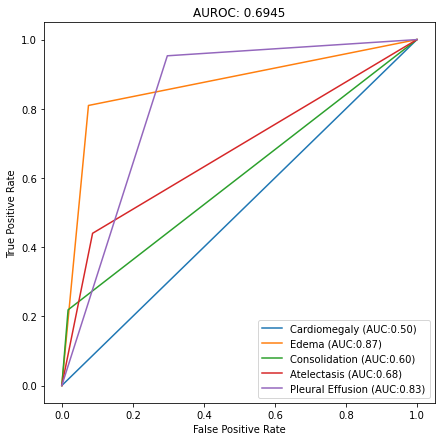

In [14]:
plot_majority_voting(test_predictions, threshold=0.2).to_csv('results/majority_voting_thr0.2.csv')
plot_majority_voting(tta_prediction_means, threshold=0.2).to_csv('results/majority_voting_thr0.2_tta.csv')

# Voting

No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-p

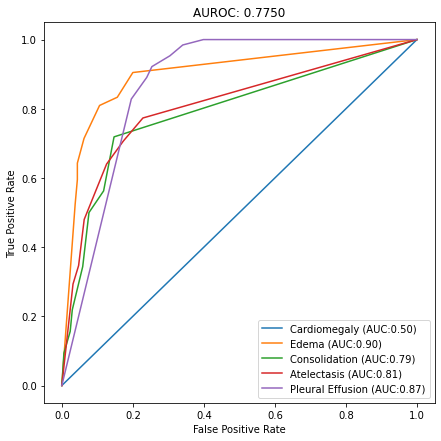

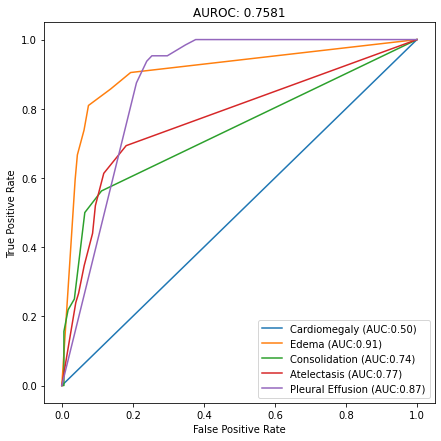

In [15]:
def plot_voting(predictions):
    from scipy.stats import entropy

    entropies = entropy([predictions,1-predictions],base = 2)

    binary_pred = predictions >= 0.2
    binary_pred = binary_pred.astype(int)
    final_pred = np.average(binary_pred,axis=0)
    final_pred = final_pred.astype(float)

    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt

    dummy_labels = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
                    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

    target_labels = ['Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']

    fig, ax = plt.subplots(1,1, figsize = (7, 7))
    j = 1
    results = pd.DataFrame()
    aurocs = []
    for (i, label) in enumerate(dummy_labels):
      fpr, tpr, thresholds = roc_curve(test_Y[:,i].astype(int), final_pred[:,i])
      if (label in target_labels):
        #ax = fig.add_subplot(2,3,j)
        score = auc(fpr, tpr)
        ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, score))
        aurocs.append(score)
        results = results.append({'Label': label, 'Score':score},ignore_index = True)
      ax.legend()
      ax.set_xlabel('False Positive Rate')
      ax.set_ylabel('True Positive Rate')
      ax.set_title('AUROC: {:0.4f}'.format(np.mean(aurocs)))
    return results
plot_voting(test_predictions).to_csv('results/voting.csv')
plot_voting(tta_prediction_means).to_csv('results/voting_tta.csv')

# Exporting Predictions


In [20]:
# Exporting predictions 
np.save('Predictions/Paper/ground_truth', np.array(test_Y))
np.save('Predictions/Paper/test_predictions_singlemodels', np.array(test_predictions))
np.save('Predictions/Paper/test_predictions_simplemean', test_predictions.mean(axis=0))
np.save('Predictions/Paper/test_predictions_weightedmean', weighted_predictions)


# Stacking

In [20]:
def build_meta_learner_dataset(models,dataset):
  predictions = []
  for model in models: 
    predictions.append(model.predict(dataset))
  predictions = np.array(predictions)
  new_pred = []
  for i in range(predictions.shape[1]):
    new_pred.append(predictions[:,i])
  new_pred = np.array(new_pred)
  X = new_pred.reshape((new_pred.shape[0],-1))

  unbatched_dataset = dataset.unbatch()
  Y = []
  for _, labels in unbatched_dataset:
    Y.append(labels.numpy())
  Y = np.array(Y)
  return X , Y

def build_meta_learner_TTA_dataset(models, predictions, test_Y):
    new_pred = list()
    for i in range(predictions.shape[1]):
        new_pred.append(predictions[:,i])
    new_pred = np.array(new_pred)
    X = new_pred.reshape((new_pred.shape[0],-1))
    return X, test_Y

In [19]:
test_predictions.shape

(7, 202, 14)

In [21]:
train_X, train_Y= build_meta_learner_dataset(models,val_dataset)

In [26]:
test_X, test_Y = build_meta_learner_TTA_dataset(models, test_predictions, test_Y)
test_X_tta, test_Y_tta = build_meta_learner_TTA_dataset(models, tta_prediction_means, test_Y)

In [45]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(verbose=10,random_state=None, max_depth=30, max_features='sqrt', min_samples_split=5, n_estimators=1400)

In [46]:
rf.fit(train_X,train_Y.astype('int'))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s


building tree 1 of 1400
building tree 2 of 1400
building tree 3 of 1400
building tree 4 of 1400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.4s remaining:    0.0s


building tree 5 of 1400
building tree 6 of 1400
building tree 7 of 1400
building tree 8 of 1400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.5s remaining:    0.0s


building tree 9 of 1400
building tree 10 of 1400
building tree 11 of 1400
building tree 12 of 1400
building tree 13 of 1400
building tree 14 of 1400
building tree 15 of 1400
building tree 16 of 1400
building tree 17 of 1400
building tree 18 of 1400
building tree 19 of 1400
building tree 20 of 1400
building tree 21 of 1400
building tree 22 of 1400
building tree 23 of 1400
building tree 24 of 1400
building tree 25 of 1400
building tree 26 of 1400
building tree 27 of 1400
building tree 28 of 1400
building tree 29 of 1400
building tree 30 of 1400
building tree 31 of 1400
building tree 32 of 1400
building tree 33 of 1400
building tree 34 of 1400
building tree 35 of 1400
building tree 36 of 1400
building tree 37 of 1400
building tree 38 of 1400
building tree 39 of 1400
building tree 40 of 1400
building tree 41 of 1400
building tree 42 of 1400
building tree 43 of 1400
building tree 44 of 1400
building tree 45 of 1400
building tree 46 of 1400
building tree 47 of 1400
building tree 48 of 1400
b

[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:  1.3min finished


RandomForestClassifier(max_depth=30, max_features='sqrt', min_samples_split=5,
                       n_estimators=1400, verbose=10)

In [47]:
stacking_predictions = np.array(rf.predict_proba(test_X))[:,:,1].T
stacking_predictions_tta = np.array(rf.predict_proba(test_X_tta))[:,:,1].T

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | el

In [41]:
stacking_predictions.shape

(202, 14)

STACKING RESULTS

No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-p

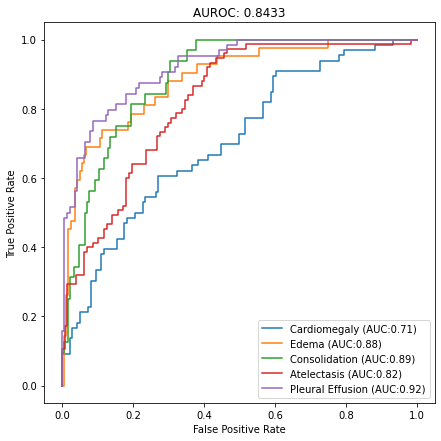

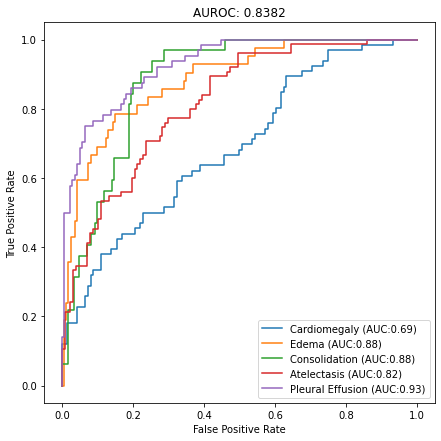

In [48]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
def plot_stacking(predictions):
    dummy_labels = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
                    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

    target_labels = ['Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']

    fig, ax = plt.subplots(1,1, figsize = (7, 7))
    j = 1
    results = pd.DataFrame()
    aurocs = []
    for (i, label) in enumerate(dummy_labels):
      fpr, tpr, thresholds = roc_curve(test_Y[:,i].astype(int), predictions[:,i])
      if (label in target_labels):
        #ax = fig.add_subplot(2,3,j)
        score = auc(fpr, tpr)
        ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, score))
        aurocs.append(score)
        results = results.append({'Label': label, 'Score':score},ignore_index = True)
      ax.legend()
      ax.set_xlabel('False Positive Rate')
      ax.set_ylabel('True Positive Rate')
      ax.set_title('AUROC: {:0.4f}'.format(np.mean(aurocs)))
    return results
plot_stacking(stacking_predictions).to_csv('results/stacking.csv')
plot_stacking(stacking_predictions_tta).to_csv('results/stacking_tta.csv')


# Embedding

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/My Drive/Models/densenet169_model.hdf5')

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

x = model.get_layer('global_average_pooling2d').output 
embedding_model = Model(inputs=model.input, outputs=x)

In [ ]:
def build_embedding_dataset(model,dataset):
  X = model.predict(dataset)
  
  unbatched_dataset = dataset.unbatch()
  Y = []
  for _,labels in unbatched_dataset:
    Y.append(labels.numpy())
  Y = np.array(Y).astype('int')  
  
  return X,Y

In [ ]:
val_X, val_Y = build_embedding_dataset(embedding_model,test_dataset)

In [ ]:
import pandas as pd 
path = '/content/drive/My Drive/Embedding/DenseNet121/validation_densenet121.csv'
df = pd.read_csv(path)

In [ ]:
val_X, val_Y = build_dataset(df)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


n_estimators = [200,500,1000]
max_depth = [5, 15, 30]
min_samples_split = [2, 10, 50]
min_samples_leaf = [1, 5, 10] 
bootstrap = ['True','False']
max_features = ['sqrt','auto']


random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


rf = RandomForestClassifier(verbose=10,random_state=42)

rf_random = RandomizedSearchCV(estimator = rf,n_iter = 100,
                               scoring='roc_auc', param_distributions= random_grid,
                               cv = 2,  n_jobs = -1,verbose=50)
rf_random.fit(val_X, val_Y.astype('int'))

In [ ]:
rf_random.best_params_

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_jobs=-1,verbose = 10 ,
                             bootstrap= True,max_depth = 30,
                             max_features= 'sqrt',
                             min_samples_leaf= 1,min_samples_split= 10,n_estimators= 200)


In [ ]:
rfc.fit(train_X,train_Y.astype(int))

In [ ]:
test_X, test_Y = build_embedding_dataset(embedding_model,test_dataset)

In [ ]:
predictions = rfc.predict_proba(test_X)
predictions = np.array(predictions)[:,:,1].T

# Embedding Ensemble

In [ ]:
def parse(x):
  return np.array(x.strip('][').split(', '),dtype=np.float32)
  
def build_dataset(df):
  df['Embedding'] = df['Embedding'].apply(lambda x: parse(x))
  values = df['Embedding'].values
  X = np.array([el for el in values])
  Y = df[df.columns[1:-1]].values
  return X, Y 

In [ ]:
import os
model_name = ['DenseNet121','DenseNet169','DenseNet201',
              'VGG16','VGG19','Xception','InceptionResNetV2']
embedding_base_path = 'EmbeddingTrained'
model_base_path = '/content/drive/My Drive/Embedding'

Link alla cartella contenente i modelli trainati: https://drive.google.com/open?id=1FghuuMDHhpNIoEmYlUxMiAngowN3Emke

In [ ]:
from joblib import dump, load
import pandas as pd

def compute_conditional_predictions(predictions):
  predictions[:,5] = predictions[:,3] * predictions[:,5]
  predictions[:,6] = predictions[:,3] * predictions[:,6]
  predictions[:,7] = predictions[:,3] * predictions[:,7]
  predictions[:,4] = predictions[:,3] * predictions[:,4]
  predictions[:,8] = predictions[:,3] * predictions[:,8]
  predictions[:,2] = predictions[:,1] * predictions[:,2]


predictions = []
for name in model_name:
    ##LOAD THE MODEL
    filename = 'embedding_rf_{}.joblib'.format(name.lower())
    model = load(os.path.join(embedding_base_path,filename))
    ##LOAD THE DATA
    dataset_name = 'test_{}.csv'.format(name.lower())

    dataset = pd.read_csv(os.path.join(model_base_path,name,dataset_name))
    test_X, _ = build_dataset(dataset)
    model_pred = model.predict_proba(test_X)
    model_pred = np.array(model_pred)[:,:,1].T
    compute_conditional_predictions(model_pred)
    predictions.append(model_pred)

final_predictions = np.array(predictions)

In [ ]:
unbatched_test = test_dataset.unbatch()
test_Y = []
for img, labels in unbatched_test:
  test_Y.append(labels.numpy())
test_Y = np.array(test_Y)

**Ensemble of the 8 Random Forest**

In [ ]:
plot_result(test_Y,np.average(final_predictions,axis=0))

# Conditional Training

In [ ]:
def record_parser(example):
    example_fmt = {
        'label': tf.io.FixedLenFeature([14], tf.float32),
        'image': tf.io.FixedLenFeature([],tf.string, default_value='')}
    parsed = tf.io.parse_single_example(example, example_fmt)
    image = tf.io.decode_png(parsed["image"],channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, parsed['label']

def normalize_image(img,labels):
    imagenet_mean = np.array([0.485, 0.456, 0.406])
    imagenet_std = np.array([0.229, 0.224, 0.225])
    img = (img - imagenet_mean) / imagenet_std
    return img,labels

def make_dataset(filename):
  base_path = '/content/drive/My Drive/tfrecords'
  full_path = os.path.join(base_path,filename)
  dataset = tf.data.TFRecordDataset(full_path)
  parsed_dataset = dataset.map(record_parser,num_parallel_calls = tf.data.experimental.AUTOTUNE)
  parsed_dataset = parsed_dataset.map(normalize_image,num_parallel_calls = tf.data.experimental.AUTOTUNE)
  return parsed_dataset

batch_size = 64
train_dataset = make_dataset('training_cropped.tfrecords').shuffle(buffer_size=128).batch(batch_size, drop_remainder=True).prefetch(1)
val_dataset = make_dataset('validation_cropped.tfrecords').batch(batch_size, drop_remainder=True).prefetch(1)
test_dataset = make_dataset('test_set_cropped.tfrecords').batch(batch_size, drop_remainder=False).prefetch(1)

In [ ]:
from tensorflow.keras.applications.nasnet import NASNetMobile
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.xception import Xception

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Activation, Lambda
from tensorflow.keras.models import Model

base_model = NASNetMobile(include_top=False,
                             weights='imagenet',
                             input_shape=(224, 224, 3))



x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(14, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
for layer in model.layers[:-1]:
  layer.trainable = False

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam

def step_decay(epoch):
  initial_lr = 1e-4
  drop = 0.1
  return initial_lr * np.power(drop,epoch)

outputFolder = '/content/drive/My Drive/ConditionalTraining/NASNetMobile/PreTrained'
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)
filepath=outputFolder+"/model-{epoch:02d}.hdf5"

lr_scheduler = LearningRateScheduler(step_decay)
early_stopping = EarlyStopping(monitor='val_AUC',mode='max',patience=4)
checkpoint_cb = ModelCheckpoint(filepath,save_best_only = False,save_weights_only = False,
                               save_freq='epoch',verbose=False)


opt = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
callbacks = [lr_scheduler,checkpoint_cb]

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy','AUC'])

In [ ]:
%%time
history = model.fit(train_dataset,
          epochs=5,
          validation_data=val_dataset,
          callbacks=callbacks,
          verbose=1,initial_epoch = 0)

Link alla cartella contenente i modelli trainati: https://drive.google.com/open?id=135mh_ET_e4eiupA-dgv_KaxOPd_RvyQ0

In [ ]:
from tensorflow.keras.models import load_model

model_names = ['DenseNet121','DenseNet169','DenseNet201','VGG16','VGG19','Xception','InceptionResNetV2']

models = []
for el in model_names:
  mod = load_model('ConditionalTraining/{}/FineTuning/model-05.hdf5'.format(el))
  models.append(mod)

In [ ]:
nn_predictions = []
for model in models:
  nn_predictions.append(compute_predictions(model))
nn_predictions = np.array(nn_predictions)

In [ ]:
plot_result(test_Y,np.average(nn_predictions,axis=0))

In [ ]:
from scipy.stats import entropy
nn_entropies = entropy([nn_predictions,1-nn_predictions],base = 2)
nn_pred = np.average(nn_predictions,axis=0, weights=1-nn_entropies)

In [ ]:
plot_result(test_Y,nn_pred)

In [ ]:
import pandas as pd 

def parse(x):
  return np.array(x.strip('][').split(', '),dtype=np.float32)
  
def build_dataset(df):
  df['Embedding'] = df['Embedding'].apply(lambda x: parse(x))
  values = df['Embedding'].values
  X = np.array([el for el in values])
  #Y = df[df.columns[1:-1]].values
  return X

# XGBoost

Link alla cartella contenente i modelli trainati: https://drive.google.com/open?id=14GfK5ix7iwtFaRVnz5zXjLGGoT1I9e4v

In [ ]:
import xgboost as xgb
import os
import pandas as pd
model_name = ['DenseNet121','DenseNet169','DenseNet201',
              'VGG16','VGG19','Xception','InceptionResNetV2']
model_base_path = '/content/drive/My Drive/XGBoost'
embedding_base_path = '/content/drive/My Drive/Embedding'

predictions = []
for name in model_name:
  dataset_name = 'test_{}.csv'.format(name.lower())
  dataset = pd.read_csv(os.path.join(embedding_base_path,name,dataset_name))
  test_X = build_dataset(dataset)

  model_pred = []
  dtest = xgb.DMatrix(test_X)
  for i in range(14):
    filename = 'xgboost_lab_{}.joblib'.format(i)
    model = load(os.path.join(model_base_path,name,filename))
    model_pred.append(model.predict(dtest))

  predictions.append(np.array(model_pred).T)


In [ ]:
plot_result(test_Y,np.average(predictions,axis=0))

# Final Result

Link ai file contenenti le predizioni: https://drive.google.com/open?id=1746ztMAbqPrihRUWTuj5iOxcKn27zUQn

In [ ]:
import numpy as np
rf_predictions = np.load('/content/drive/My Drive/Predictions/nn_pred_no_entropy.npy')
nn_predictions = np.load('/content/drive/My Drive/Predictions/rf_pred_no_entropy.npy')
xgb_predictions = np.load('/content/drive/My Drive/Predictions/xgb_pred_no_entropy.npy')

In [ ]:
from scipy.stats import entropy
rf_entropies = entropy([rf_predictions,1-rf_predictions],base = 2)
nn_entropies = entropy([nn_predictions,1-nn_predictions],base = 2)
xgb_entropies = entropy([xgb_predictions,1-xgb_predictions],base = 2)

In [ ]:
rf_pred = np.average(rf_predictions,axis=0, weights=1-rf_entropies)
nn_pred = np.average(nn_predictions,axis=0, weights=1-nn_entropies)
xgb_pred = np.average(xgb_predictions,axis=0,weights=1-xgb_entropies)

In [ ]:
final_predictions = np.average([rf_pred,nn_pred,xgb_pred],axis=0)

In [ ]:
plot_result(test_Y,final_predictions)

In [ ]:
fin_pred = np.load('/content/drive/My Drive/Predictions/final_predictions.npy')
thresholds = np.load('/content/drive/My Drive/Predictions/thresholds.npy')

for i in range(fin_pred.shape[1]):
  threshold = thresholds[i]
  negative_label = (np.logical_and(fin_pred[:,i] >=0, fin_pred[:,i] <threshold-0.15*threshold))
  uncertain = (np.logical_and(fin_pred[:,i]>=threshold-0.15*threshold, fin_pred[:,i]<=threshold+0.15*threshold))
  positive_label = (np.logical_and(fin_pred[:,i]>=threshold+0.15*threshold, fin_pred[:,i]<=1))
  fin_pred[:,i][negative_label] = 0
  fin_pred[:,i][uncertain] = -1
  fin_pred[:,i][positive_label] = 1


In [ ]:
def compute_confusion_matrix(true_labels,predicted_labels):
  tp = 0 
  tn = 0 
  fp = 0 
  fn = 0 
  uncertain = 0 
  for true,predicted in zip(true_labels,predicted_labels):
    if predicted == -1:
      uncertain += 1
    if true == 1 and predicted == 1:
      tp += 1
    if true == 0 and predicted == 0:
      tn += 1
    if true == 0 and predicted == 1:
      fp +=1
    if true == 1 and predicted == 0:
      fn +=1
  return np.array([[tp,fn],[fp,tn]]),uncertain



In [ ]:
import seaborn as sns

idxs = [2,5,6,8,10]
label_name = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
                'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

for i in idxs:
  cm, uncertain = compute_confusion_matrix(test_Y[:,i],fin_pred[:,i])
  fig = plt.figure(figsize=(5,5))
  sns.heatmap(cm,annot=True,fmt='d',cmap='Reds',cbar = False,yticklabels=[1,0],xticklabels=[1,0])
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.title('{}'.format(label_name[i]))
  plt.show()
  spec = cm[1][1] / (cm[1][1] + cm[1][0])
  sensib = cm[0][0] / (cm[0][0] + cm[0][1])
  prec = cm[0][0] / (cm[0][0] + cm[1][0])
  f1 = (2*prec*sensib)/(prec+sensib)
  print('Uncertain labels: {}'.format(uncertain))
 